# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools

delphesDir = os.path.abspath("../delphes-3.5.1pre10")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT

ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

import sys
sys.path.append('../recastCode')
from helper import getFourMom,getJetTracks

plt.style.use('fivethirtyeight') #Set style
plt.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [2]:
# inputFile = '../pp2ZH/Events/run_02/ctau_1000mm_delphes_events.root'
# ctau = float(inputFile.split('ctau_')[1].split('mm')[0])
inputFile = '../HZcms_1000mm_trkRes.root'
ctau = 1000.0


In [3]:
vars = ['IP2D', 'theta2D', 'alpha','pT','d0','sigmaD0','weights']
resDict = {v : [] for v in vars}


f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
for ievt in range(nevts):
    tree.GetEntry(ievt)   
    # weightPB = tree.Event.At(0).Weight/nevts
    weightPB = 1.0
    jets = tree.Jet
    # jets = tree.GenJet
    tracks = tree.Track  
    
          
    #Apply lepton cut requirement:
    electrons = tree.Electron
    muons = tree.Muon
    passLepton = False
    if len(electrons) >= 2:
        ePlus = [e for e in electrons if e.Charge > 0]
        eMinus = [e for e in electrons if e.Charge < 0]
        for eP,eM in itertools.product(ePlus,eMinus):
            p1 = getFourMom(eP,mass=0.511e-3)
            p2 = getFourMom(eM,mass=0.511e-3)
            p12 = p1+p2       
            mll = np.sqrt(p12[0]**2 - np.dot(p12[1:],p12[1:]))
            pTll = np.linalg.norm(p12[1:3])
            if pTll > 100.0 and (70.0 < mll < 110.):
                passLepton = True
                break
    if not passLepton and len(muons) >= 2:
        muPlus = [mu for mu in muons if mu.Charge > 0]
        muMinus = [mu for mu in muons if mu.Charge < 0]
        for muP,muM in itertools.product(muPlus,muMinus):
            p1 = getFourMom(muP,mass=106e-3)
            p2 = getFourMom(muM,mass=106e-3)
            p12 = p1+p2       
            mll = np.sqrt(p12[0]**2 - np.dot(p12[1:],p12[1:]))
            pTll = np.linalg.norm(p12[1:3])
            if pTll > 100.0 and (70.0 < mll < 110.):
                passLepton = True
                break
    
    if not passLepton:
        continue

    for j in jets:
        if j.PT < 35.0:
            continue
        if abs(j.Eta) > 2.4:
            continue
        jet_tracks = getJetTracks(j,tracks,Rmax=None)
        ipList = []
        for track in jet_tracks:
            d0Err = track.ErrorD0
            if not d0Err:
                continue
            d0 = track.D0
            resDict['d0'].append(d0)
            resDict['sigmaD0'].append(d0Err)
            ipT = np.log10(abs(d0)/d0Err)
            ipList.append(ipT)
        ip2D = np.median(ipList)
        resDict['pT'].append(j.PT)
        resDict['IP2D'].append(ip2D)    

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Plot Distributions

In [4]:
cmsIP2D = np.genfromtxt('../CMS_data/HEPData-ins1954276-v1-Figure_002-a.csv',skip_footer=0,skip_header=148,delimiter=',')
bins = cmsIP2D[:-1,0]-np.diff(cmsIP2D[:,0])/2

In [5]:
title = r'$c\tau_s = %1.0f$ mm' %(ctau)
colors = sns.color_palette('Paired')

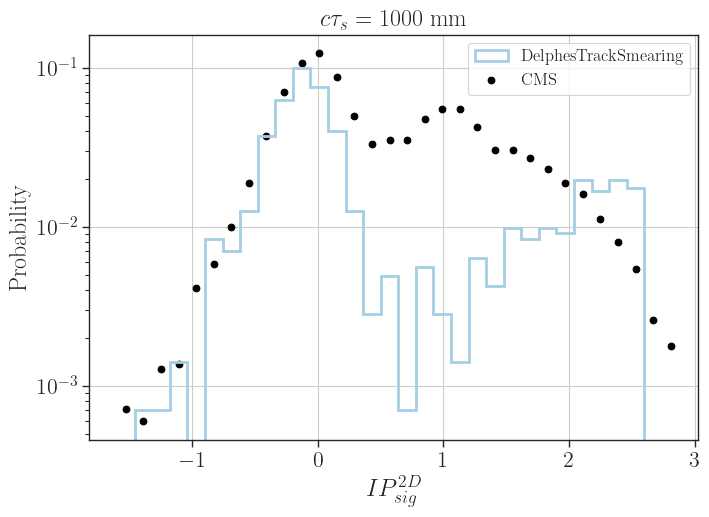

In [6]:
fig = plt.figure(figsize=(7,5))

IP2D = resDict['IP2D']
label = 'DelphesTrackSmearing'

h1,_,_ = plt.hist(IP2D,histtype='step',linewidth=2,bins=bins,density=False,
                    weights=[1.0/len(IP2D)]*len(IP2D),label=label,color=colors[0])
plt.scatter(cmsIP2D[:,0],cmsIP2D[:,1],label='CMS',color='black')
# np.savetxt('./ip2d_1mm.csv',list(zip(bins,h1)),header='bin,bin_content',delimiter=',',fmt='%1.4e')
plt.legend(fontsize=12)
plt.yscale('log')
# plt.ylim(1e-2,10)
# plt.xlim(-1.5,3.0)
plt.grid()
plt.xlabel(r'$IP_{sig}^{2D}$',fontsize=18)
plt.ylabel('Probability')
plt.title(title)

# plt.tight_layout()
plt.savefig('IP2D_1000mm_trkRes.png')
plt.show()